# Celebrity Look a Like CNN DL Project

#### Mohamed Youssef - 211001821


## Index


-   [Including Necessary Libraries](#libs)
    <br>
-   [Other Utilites](#uti)
    <br>
-   [Loading & Cleaning the Data](#dataset)
    - [Reading Meta Data](#metadata)
    - [Creating Data Frame](#dataframe)
    - [Data Cleaning](#clean)
    <br>
-   [Visualization](#vis)
    -   [Univariate Exploration](#univis)
    -   [Bivariate Exploration](#bivis)
    <br>
-   [Preprocessing Data](#pre)
    -   [Getting Image Pixels](#pix)
    -   [Normalizing the Images](#norm)


## Including Necessary Librariess<a id='libs'></a>


In [1]:
# Disabling warnings
import warnings


def warn(*args, **kwargs):
    pass


warnings.warn = warn

In [67]:
# Python built-in libraries
# Todo: Include only necessary libraries
# Todo: Create a requirements.txt file


from datetime import datetime, timedelta
import time
import os

# Other libraries
import chime

# Libraries for preprocessing and visualizing the data
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import glob

# OpenCV library for image processing
import cv2

# Tensorflow and Keras libraries for deep learning models
import tensorflow as tf

import keras
from keras.utils import img_to_array
import keras.utils as image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import (
    Dense,
    Activation,
    Dropout,
    Flatten,
    Input,
    Convolution2D,
    ZeroPadding2D,
    MaxPooling2D,
    Activation,
)
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from keras import metrics
from keras.models import model_from_json
from keras.utils.vis_utils import plot_model


# Sklearn train test split function
from sklearn.model_selection import train_test_split

## Other Utilites<a id='uti'></a>


In [3]:
# Setting the path to the current directory
dataset_path = "C:/Data Sets/CLA Dataset"
print("Dataset path is: " + dataset_path)

Dataset path is: C:/Data Sets/CLA Dataset


In [4]:
# Configuring the GPU for training the model
# Todo: Detect Nvidia GPU and configure it for training the model
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    print("GPUs Available: ", gpus)

    try:
        tf.config.experimental.set_visible_devices(gpus[1], "GPU")
        tf.config.experimental.set_memory_growth(gpus[1], True)

    except:
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("No GPU Available")

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Initializing chime
chime.theme("mario")
chime.notify_exceptions()

In [6]:
# Check if the user wants to download the dataset
download_dataset = False

In [8]:
# Downloading the imdb_crop dataset from the link into the current/Data directory
if download_dataset == False:
    raise SystemExit("Dataset not downloaded. Please download the dataset, if you already have the dataset ignore this message.")
    
!wget -P "{dataset_path}" https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar

SystemExit: Dataset not downloaded. Please download the dataset, if you already have the dataset ignore this message.

In [9]:
# Extracting the dataset from the tar file
if download_dataset == False:
    raise SystemExit("Dataset not extracted. Please extract the dataset, if you already have extracted the dataset ignore this message.")
    
!tar -xvf "{dataset_path}"/imdb_crop.tar -C "{dataset_path}"/imdb_crop

SystemExit: Dataset not extracted. Please extract the dataset, if you already have extracted the dataset ignore this message.

## Loading & Cleaning the Data <a id='dataset'></a>


### Reading Meta Data <a id='metadata'></a>


In [10]:
# Loading the mat file containing the data
data_mat = scipy.io.loadmat(dataset_path + "/imdb_crop/imdb_crop/imdb.mat")

In [11]:
# Getting the total number of records in the data
records = data_mat["imdb"][0][0][0].shape[1]
print("Total no. of records:", records)

Total no. of records: 460723


In [12]:
# Getting the column names of the data
features = data_mat["imdb"][0][0].dtype
features = list(features.names)
print("Total no. of features:", len(features))

Total no. of features: 10


In [13]:
# Rename the columns of the data
print("Current Features Names:\n", features)
features[0] = "Date of Birth"
features[1] = "Photo Taken Date"
features[2] = "Full Img Path"
features[3] = "Gender"
features[4] = "Celebrity Name"
features[5] = "Face Location"
features[6] = "Face Score"
features[7] = "Second Face Score"
features[8] = "Celeb Names"
features[9] = "Celeb ID"
print("New Features Names:\n", features)

Current Features Names:
 ['dob', 'photo_taken', 'full_path', 'gender', 'name', 'face_location', 'face_score', 'second_face_score', 'celeb_names', 'celeb_id']
New Features Names:
 ['Date of Birth', 'Photo Taken Date', 'Full Img Path', 'Gender', 'Celebrity Name', 'Face Location', 'Face Score', 'Second Face Score', 'Celeb Names', 'Celeb ID']


### Creating Data Frame <a id='dataframe'></a>


In [14]:
# Creating a dataframe to store the data
data_df = pd.DataFrame(index=(range(0, records)), columns=features)

In [15]:
# Extracting the data from the mat file and storing it in a dataframe
for i in data_mat:
    if i == "imdb":
        current_array = data_mat[i][0][0]
        for j in range(len(current_array)):
            data_df[features[j]] = pd.DataFrame(current_array[j][0])

In [16]:
# Displaying 5 random rows of the data
data_df.sample(5)

,Date of Birth,Photo Taken Date,Full Img Path,Gender,Celebrity Name,Face Location,Face Score,Second Face Score,Celeb Names,Celeb ID
92090,711968,1986,[21/nm0001021_rm1697943040_1949-4-20_1986.jpg],0.0,[Veronica Cartwright],"[[265.5318338757999, 792.4995016273996, 432.86...",1.252984,NaN,NaN,19603
427849,714088,1995,[92/nm0680392_rm292800512_1955-2-8_1995.jpg],1.0,[Ethan Phillips],"[[1006.1799609339704, 1134.7927764383257, 1234...",4.916982,4.262316,NaN,6129
221133,724711,2004,[75/nm1312575_rm2965736192_1984-3-10_2004.jpg],0.0,[Olivia Wilde],"[[56.886, 120.75800000000001, 127.744000000000...",3.630672,3.540831,NaN,14826
161671,713276,2014,[48/nm0005148_rm878693120_1952-11-18_2014.jpg],1.0,[Delroy Lindo],"[[364.7719759624954, 73.75439519249909, 582.03...",4.707515,NaN,NaN,4946
234898,710950,1981,[76/nm0816876_rm1804258816_1946-7-7_1981.jpg],1.0,[Joe Spano],"[[1923, 243, 2352, 672]]",1.833961,1.142984,NaN,9371


In [17]:
# Describing the data
data_df.describe()

,Date of Birth,Photo Taken Date,Gender,Face Score,Second Face Score,Celeb ID
count,460723.000000,460723.000000,452261.000000,4.607230e+05,213797.000000,460723.000000
mean,718987.731774,2005.461555,0.581996,-inf,2.452904,10116.802404
std,13253.963535,9.054475,0.493231,NaN,1.064432,5742.153266
min,47.000000,1961.000000,0.000000,-inf,0.730926,1.000000
25%,716370.000000,2004.000000,0.000000,1.757891e+00,1.583692,5294.000000
50%,719935.000000,2008.000000,1.000000,2.980097e+00,2.355163,10066.000000
75%,723073.000000,2011.000000,1.000000,4.006376e+00,3.228071,14922.000000
max,734963.000000,2015.000000,1.000000,7.381689e+00,6.395435,20284.000000


In [18]:
# Checking for null values in the data
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460723 entries, 0 to 460722
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date of Birth      460723 non-null  int32  
 1   Photo Taken Date   460723 non-null  uint16 
 2   Full Img Path      460723 non-null  object 
 3   Gender             452261 non-null  float64
 4   Celebrity Name     460723 non-null  object 
 5   Face Location      460723 non-null  object 
 6   Face Score         460723 non-null  float64
 7   Second Face Score  213797 non-null  float64
 8   Celeb Names        20284 non-null   object 
 9   Celeb ID           460723 non-null  uint16 
dtypes: float64(3), int32(1), object(4), uint16(2)
memory usage: 28.1+ MB


### Data Cleaning <a id='clean'></a>


In [19]:
# Removing pictures with no face detected
data_df = data_df[data_df["Face Score"] != -np.inf]
print("Total no. of records with no face detected removed:", records - len(data_df))
records = len(data_df)  # Updating the total number of records
print("Total no. of records after removing records with no face detected:", records)

Total no. of records with no face detected removed: 62302
Total no. of records after removing records with no face detected: 398421


In [20]:
# Removing pictures with more than one face detected
data_df = data_df[data_df["Second Face Score"].isna()]
print(
    "Total no. of records with more than one face detected removed:",
    records - len(data_df),
)
records = len(data_df)  # Updating the total number of records
print("Total no. of records after removing pictures with more the one face:", records)

Total no. of records with more than one face detected removed: 213797
Total no. of records after removing pictures with more the one face: 184624


In [21]:
# Creating a function to extract first index of an array
def extract_data(arr):
    return arr[0]

In [22]:
# Extracting the data from the array columns of the dataframe
data_df["Celebrity Name"] = data_df["Celebrity Name"].apply(extract_data)
data_df["Full Img Path"] = data_df["Full Img Path"].apply(extract_data)

In [23]:
# Dropping the unnecessary columns from the dataframe
data_df.drop(
    ["Celeb ID", "Celeb Names", "Second Face Score", "Face Location"],
    axis=1,
    inplace=True,
)

In [24]:
# Creating a function to convert the matlab serial date number to python date time object
def convert_date(date_number):
    str_date = str(date_number)
    # If the length of the string is 4, then the date is in the format YYYY
    if len(str_date) == 4:
        full_date = datetime.strptime(str_date, "%Y")
        return full_date.strftime("%Y")
    else:
        try:
            date_time = (
                datetime.fromordinal(int(date_number))
                + timedelta(days=date_number % 1)
                - timedelta(days=366)
            )
            return date_time
        except OverflowError:
            return pd.NaT

In [25]:
# Converting the matlab serial date number to python date time object
data_df["Date of Birth"] = data_df["Date of Birth"].apply(convert_date)

In [26]:
# Converting the Photo Taken Date to python year date time object
data_df["Photo Taken Date"] = data_df["Photo Taken Date"].apply(convert_date)

In [27]:
# Creating a function to calculate the age of the celebrity
def calculate_age_at_photo(born, photo_taken):
    photo_taken = datetime.strptime(photo_taken, "%Y")
    try:
        return (
            photo_taken.year
            - born.year
            - ((photo_taken.month, photo_taken.day) < (born.month, born.day))
        )
    except AttributeError:
        return np.nan

In [28]:
# Calculating the age of the celebrity
data_df["Age at Photo"] = data_df.apply(
    lambda x: calculate_age_at_photo(x["Date of Birth"], x["Photo Taken Date"]), axis=1
)
# Changing the datatype of the age column to integer
data_df["Age at Photo"] = data_df["Age at Photo"].astype("Int64")

In [29]:
# Creating a function to calculate the current age of the celebrity
def calculate_age(born):
    today = datetime.today()
    try:
        return (
            today.year - born.year - ((today.month, today.day) < (born.month, born.day))
        )
    except AttributeError:
        return np.nan

In [30]:
# Calculating the current age of the celebrity
data_df["Current Age"] = data_df["Date of Birth"].apply(calculate_age)
# Changing the datatype of the age column to integer
data_df["Current Age"] = data_df["Current Age"].astype("Int64")

In [31]:
# Dropping the Date of Birth and Photo Taken Date columns
data_df.drop(["Date of Birth", "Photo Taken Date"], axis=1, inplace=True)

In [32]:
# Dropping any rows with null values
data_df.dropna(inplace=True)
print("Total no. of records with null values removed:", records - len(data_df))
records = len(data_df)  # Updating the total number of records
print("Total no. of records after removing null values:", len(data_df))

Total no. of records with null values removed: 2990
Total no. of records after removing null values: 181634


In [33]:
# Removing the records with age at photo less than 0
data_df = data_df[data_df["Age at Photo"] >= 0]
print("Total no. of records with -ve age removed:", records - len(data_df))
records = len(data_df)  # Updating the total number of records
print("Total no. of records after removing -ve age values:", len(data_df))

Total no. of records with -ve age removed: 154
Total no. of records after removing -ve age values: 181480


In [34]:
# Changing the datatype of the gender column to integer
data_df["Gender"] = data_df["Gender"].astype(int)

In [35]:
# Reordering the columns of the dataframe
data_df = data_df.reindex(
    columns=[
        "Celebrity Name",
        "Gender",
        "Current Age",
        "Age at Photo",
        "Full Img Path",
        "Face Score",
    ]
)

In [36]:
# Keep only unique celebrities in the data with the highest face score
data_df = data_df.sort_values(by=["Face Score"], ascending=False)
data_df.drop_duplicates(subset="Celebrity Name", keep="first", inplace=True)
print(
    "Total no. of records with duplicate celebrities removed:", records - len(data_df)
)
records = len(data_df)  # Updating the total number of records
print("Total no. of records after removing duplicate celebrities:", len(data_df))

Total no. of records with duplicate celebrities removed: 166870
Total no. of records after removing duplicate celebrities: 14610


In [37]:
# Filtering the data to keep only celebrities with a face score of 3 or more
data_df = data_df[data_df["Face Score"] >= 3]
print("Total no. of records with low face score removed:", records - len(data_df))
records = len(data_df)  # Updating the total number of records
print("Total no. of records after removing low face scores values:", len(data_df))

Total no. of records with low face score removed: 3193
Total no. of records after removing low face scores values: 11417


In [38]:
# Dropping the Face Score column
data_df.drop(["Face Score"], axis=1, inplace=True)

In [39]:
# Resetting the index of the dataframe
data_df.reset_index(drop=True, inplace=True)

In [40]:
# Displaying 5 random rows of the data
data_df.sample(5)

,Celebrity Name,Gender,Current Age,Age at Photo,Full Img Path
6051,Madison Davenport,0,27,15,78/nm1956478_rm1624156160_1996-11-22_2012.jpg
3425,Kelli Giddish,0,43,29,07/nm1534207_rm4193552640_1980-4-13_2010.jpg
684,Mark Hengst,1,59,49,17/nm1936317_rm263701248_1964-3-7_2014.jpg
1381,Addison Timlin,0,32,22,70/nm1789970_rm565167104_1991-6-29_2014.jpg
4274,Kyle Richards,0,54,40,02/nm0724202_rm2238678016_1969-1-11_2010.jpg


In [41]:
# Describing the data
data_df.describe()

,Gender,Current Age,Age at Photo
count,11417.000000,11417.0,11417.0
mean,0.572304,55.428659,35.96076
std,0.494766,17.634418,14.467294
min,0.000000,16.0,0.0
25%,0.000000,43.0,26.0
50%,1.000000,52.0,34.0
75%,1.000000,65.0,44.0
max,1.000000,147.0,133.0


In [42]:
# Checking for null values in the data
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11417 entries, 0 to 11416
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Celebrity Name  11417 non-null  object
 1   Gender          11417 non-null  int32 
 2   Current Age     11417 non-null  Int64 
 3   Age at Photo    11417 non-null  Int64 
 4   Full Img Path   11417 non-null  object
dtypes: Int64(2), int32(1), object(2)
memory usage: 423.8+ KB


## Visualization <a id="vis"></a>


### Univariate Exploration <a id="univis"></a>


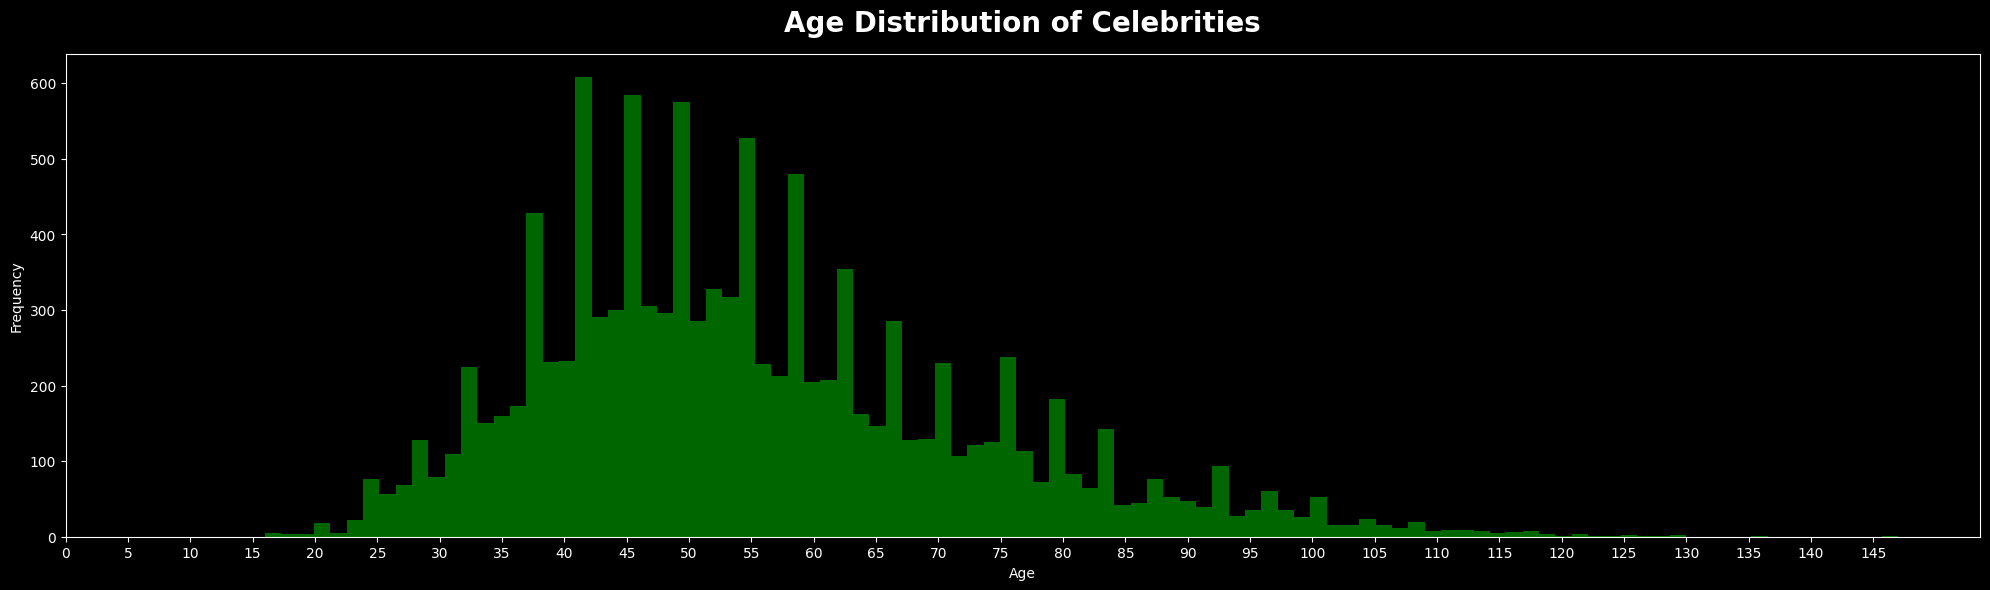

In [43]:
# Plotting the distribution of the age of the celebrities
plt.figure(figsize=(20, 6))
plt.hist(data_df["Current Age"], bins=100, color="green", alpha=0.8)
max_age = data_df["Current Age"].max()
plt.xticks(range(0, max_age, 5))
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution of Celebrities", fontsize=20, fontweight="bold", y=1.03)
plt.tight_layout()
plt.show()

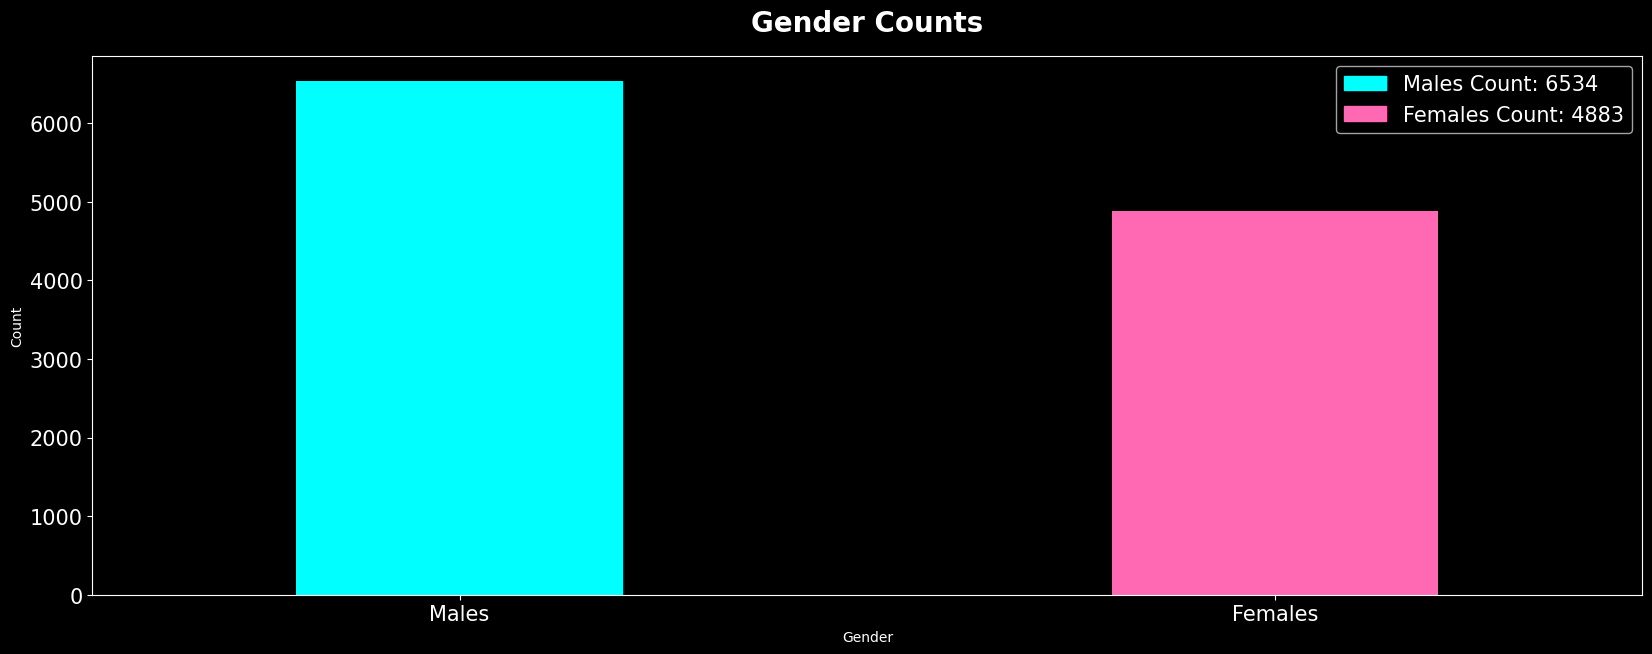

In [44]:
# Plotting the distribution genders in the celebrities dataset
gender_counts = data_df["Gender"].value_counts()
gender_counts.rename({0: "Females", 1: "Males"}, inplace=True)

plt.figure(figsize=(20, 7))
gender_counts.plot(kind="bar", color=["aqua", "hotpink"], rot=0, width=0.4)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel("Gender")
plt.ylabel("Count")

plt.title("Gender Counts", fontsize=20, fontweight="bold", y=1.03)

females_patch = mpatches.Patch(
    color="hotpink", label=f"Females Count: {gender_counts[1]}"
)
males_patch = mpatches.Patch(color="aqua", label=f"Males Count: {gender_counts[0]}")
plt.legend(handles=[males_patch, females_patch], fontsize=15)

plt.show()

### Bivariate Exploration <a id="bivis"></a>


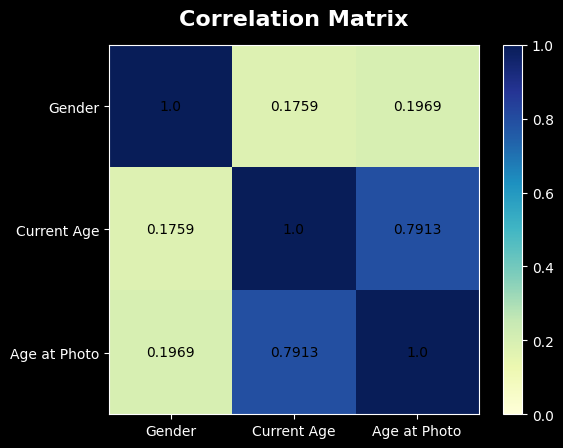

In [45]:
# Plotting the correlation matrix of the data using a heatmap
corr = data_df[["Gender", "Current Age", "Age at Photo"]].corr()
plt.imshow(corr, cmap="YlGnBu", interpolation="nearest", vmin=0, vmax=1)
plt.colorbar()

for i in range(3):
    for j in range(3):
        plt.annotate(
            str(round(corr.values[i][j], 4)),
            xy=(j, i),
            ha="center",
            va="center",
            color="black",
        )

plt.title("Correlation Matrix", fontsize=16, fontweight="bold", y=1.03)

plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.show()

In [46]:
# Todo: Ask about Multivariate Exploration

## Preprocessing Data <a id='pre'></a>


### Getting Images Pixels <a id='pix'></a>


In [47]:
# Creating a function to load the image pixels from the dataset
def load_imgs(path):
    return cv2.imread(dataset_path + "/imdb_crop/imdb_crop/" + path)

In [48]:
# Loading the image pixels from the path
data_df["Image Pixels"] = data_df["Full Img Path"].apply(load_imgs)

In [49]:
# Dropping the Full Img Path column
data_df.drop("Full Img Path", axis=1, inplace=True)

In [50]:
# Displaying 5 random rows of the data
data_df.sample(5)

,Celebrity Name,Gender,Current Age,Age at Photo,Image Pixels
9784,Ólafur Darri Ólafsson,1,50,40,"[[[208, 197, 217], [208, 197, 217], [208, 197,..."
1776,Craig T. Nelson,1,79,64,"[[[204, 206, 207], [204, 206, 207], [204, 206,..."
2474,Chiara Mastroianni,0,51,38,"[[[219, 212, 197], [219, 212, 197], [219, 212,..."
8844,Radivoje Bukvic,1,44,31,"[[[72, 69, 141], [72, 69, 141], [73, 69, 141],..."
1790,Dave Grohl,1,54,36,"[[[27, 49, 74], [27, 49, 74], [27, 49, 74], [2..."


In [51]:
# Displaying the datatype of the image pixels column
print("Datatype of the image pixels column:", type(data_df["Image Pixels"][0]))

Datatype of the image pixels column: <class 'numpy.ndarray'>


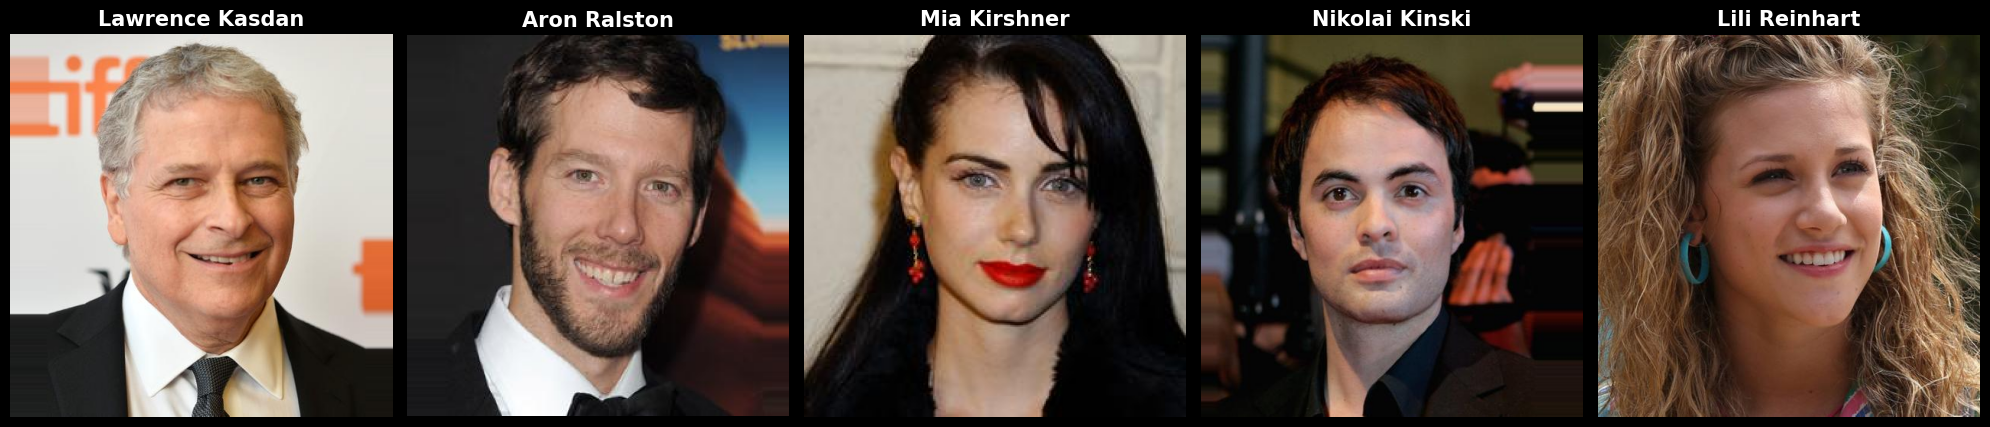

In [52]:
# Displaying 5 random images of celebrities
plt.figure(figsize=(20, 6))
for i in range(5):
    random_index = np.random.randint(0, len(data_df))  # Selecting a random index
    img_pixels = data_df["Image Pixels"][random_index]
    img_pixels = cv2.cvtColor(img_pixels, cv2.COLOR_BGR2RGB)  # Apply color conversion
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pixels)
    plt.title(data_df["Celebrity Name"][random_index], fontsize=15, fontweight="bold")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Normalizing the Images <a id='norm'></a>


In [53]:
# Creating a function to resize and normalize the image pixels
def resize_normalize_img(img):
    # resize image to 224x224
    img = cv2.resize(img, (224, 224))
    # convert image to numpy array of shape (224, 224, 3)
    img_pixels = image.img_to_array(img)
    img_pixels = np.expand_dims(img_pixels, axis=0)
    # normalize the image pixels to the range of [-1, +1]
    img_pixels /= 127.5
    img_pixels -= 1
    return img_pixels

In [54]:
# Resizing and normalizing the image pixels
data_df["Normalized Image Pixels"] = data_df["Image Pixels"].apply(resize_normalize_img)

In [55]:
# Displaying 5 random rows of the data
data_df.sample(5)

,Celebrity Name,Gender,Current Age,Age at Photo,Image Pixels,Normalized Image Pixels
8760,T Bone Burnett,1,75,64,"[[[222, 220, 220], [222, 220, 220], [222, 220,...","[[[[0.73333335 0.7176471 0.7176471 ], [0.7333..."
9353,Frank Collison,1,73,53,"[[[60, 62, 73], [60, 62, 73], [60, 62, 73], [5...","[[[[-0.5294118 -0.5137255 -0.42745095], [-0...."
2415,Atticus Mitchell,1,30,18,"[[[38, 85, 207], [38, 85, 207], [38, 85, 207],...","[[[[-0.7019608 -0.3333333 0.62352943], [-0...."
9847,Gina Lollobrigida,0,96,37,"[[[44, 75, 208], [40, 71, 204], [36, 67, 200],...","[[[[-0.654902 -0.41176468 0.6313726 ], [-0...."
3936,Kelly Blatz,1,36,22,"[[[251, 251, 251], [251, 251, 251], [251, 251,...","[[[[0.96862745 0.96862745 0.96862745], [0.9686..."


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


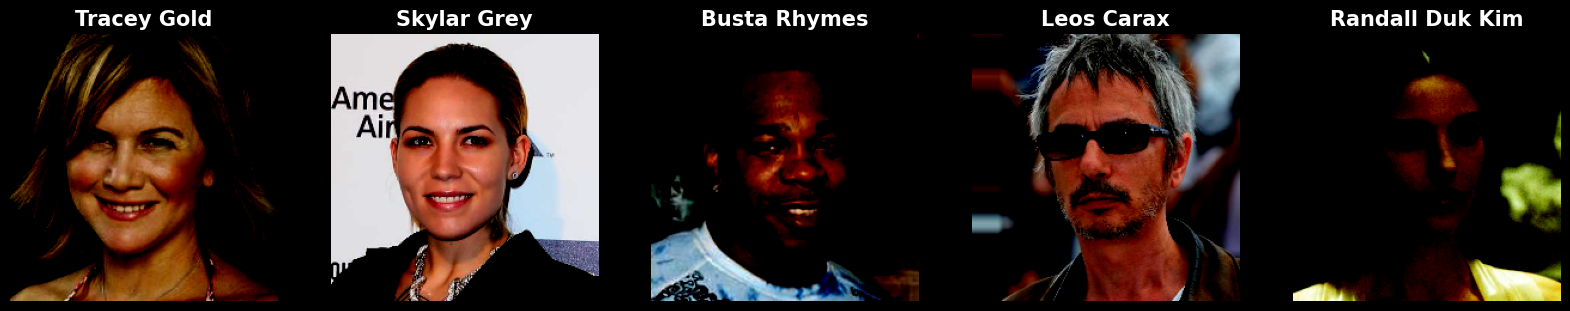

In [56]:
# Displaying 5 random normalized images of celebrities
plt.figure(figsize=(20, 6))
for i in range(5):
    random_index = np.random.randint(0, len(data_df))  # Selecting a random index
    img_pixels = data_df["Normalized Image Pixels"][random_index]
    img_pixels = img_pixels[0]  # Removing the extra dimension
    img_pixels = cv2.cvtColor(img_pixels, cv2.COLOR_BGR2RGB)  # Apply color conversion
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pixels)
    plt.title(data_df["Celebrity Name"][random_index], fontsize=15, fontweight="bold")
    plt.axis("off")

In [57]:
# Showing the dimensions of the image pixels
print("Dimensions of the image pixels:", data_df["Normalized Image Pixels"][2].shape)

Dimensions of the image pixels: (1, 224, 224, 3)


## Neural Network Construction


### Building the Network (Vgg Face Descriptor Model)

In [58]:
# Initializing the vgg face descriptor model for face recognition
model = Sequential()

# Adding the first chunk of layers to the model as per the vgg face descriptor model architecture
# (64 filters per convolutional layer (2))
# Before every convolutional layer in chunks 1 to 5, a zero padding layer is added to preserve more spatial information
# At the end of chunks 1 to 5, a max pooling layer is added to reduce the spatial dimensions of the image

# Adding the first zero padding to the input image pixels making them 226 x 226 to preserve more spatial information
model.add(ZeroPadding2D((1, 1), input_shape=(224, 224, 3)))
# Adding the first convolutional layer with 64 filters of size 3 x 3 and relu activation function
model.add(Convolution2D(64, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, (3, 3), activation="relu"))
model.add(
    MaxPooling2D((2, 2), strides=(2, 2))
)  # Adding the first max pooling layer with a pool size of 2 x 2 and stride of 2 x 2 to reduce
# the spatial dimensions of the image

# Adding the second chunk of layers to the model as per the vgg face descriptor model architecture
# (128 filters per convolutional layer (2))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Adding the third chunk of layers to the model as per the vgg face descriptor model architecture
# (256 filters per convolutional layer (3))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Adding the fourth chunk of layers to the model as per the vgg face descriptor model architecture
# (512 filters per convolutional layer (3))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Adding the fifth chunk of layers to the model as per the vgg face descriptor model architecture
# (512 filters per convolutional layer (3))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Adding the sixth chunk of layers to the model as per the vgg face descriptor model architecture
# (4096 neurons per dense layer (2))

model.add(
    Convolution2D(4096, (7, 7), activation="relu")
)  # Adding the first 'dense' layer with 4096 neurons and relu activation function this is
# considered a dense layer because it has a kernel size of 7 x 7 which is the same as the spatial dimensions of the image
model.add(
    Dropout(0.5)
)  # Adding a dropout layer with a dropout rate of 50% to prevent overfitting
model.add(Convolution2D(4096, (1, 1), activation="relu"))
model.add(Dropout(0.5))

# Adding the seventh chunk of layers to the model as per the vgg face descriptor model architecture
# (2622 neurons per dense layer (1))

model.add(Convolution2D(2622, (1, 1)))
model.add(
    Flatten()
)  # Adding a flatten layer to flatten the output of the previous layer to a 1D vector

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

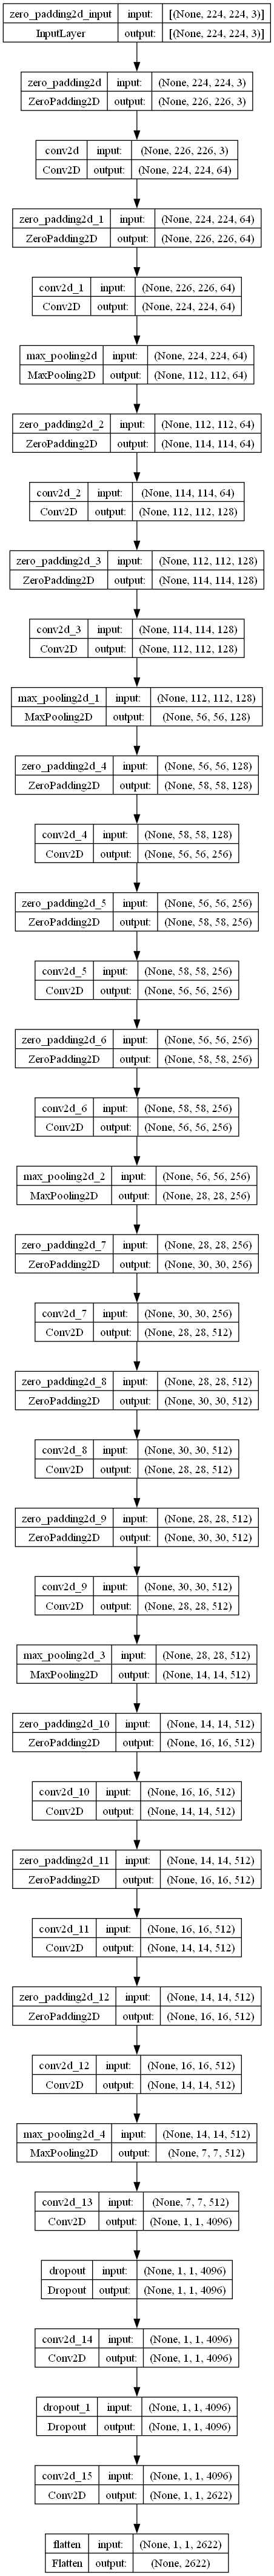

In [59]:
# Visualizing the model architecture as a graph
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

### Importing Weights

In [60]:
# Check if the user wants to download the weights of the model
download_weights = False

In [66]:
# Downloading the imdb_crop dataset from the link into the current/Data directory
if download_weights == False:
    raise SystemExit("Vgg face descriptor Model weights not downloaded. Please download the weights, if you already have the weights ignore this message.")
    
!wget -P "{dataset_path}" https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar

SystemExit: Vgg Face Model weights not downloaded. Please download the weights, if you already have the weights ignore this message.

In [62]:
# Load Vgg Face Model Weights
model.load_weights("Model/vgg_face_weights.h5")

### Predicting Face Vector Representaion

In [63]:
# Creating a to get vector face representation of the image
def get_vector_face(norm_img_pixels):
    # Getting the face vector representation of the image pixels from the model output
    face_vector = model.predict(norm_img_pixels)[0, :]
    return face_vector

In [64]:
# Getting the face vector representation of the normalized image pixels
tic = time.time()
data_df["Face Vector"] = data_df["Normalized Image Pixels"].apply(get_vector_face)
toc = time.time()
face_vector_time = str(timedelta(seconds=toc - tic))
print("Time taken to get face vectors:", face_vector_time, "seconds")

1/1 [==============================] - 0s 21ms/step
Time taken to get face vectors: 1101.468108177185 seconds


In [187]:
# Displaying 5 random rows of the data
data_df.sample(5)

,Celebrity Name,Gender,Current Age,Age at Photo,Image Pixels,Normalized Image Pixels,Face Vector
2912,Chris O'Donnell,1,53,33,"[[[0, 2, 3], [0, 2, 3], [0, 2, 3], [0, 2, 3], ...","[[[[-1. -0.9843137 -0.9764706], [-1. ...","[0.03202045, -0.023105966, -0.00078073307, 0.0..."
828,Christine Woods,0,40,25,"[[[152, 147, 148], [152, 147, 148], [152, 147,...","[[[[0.19215691 0.15294123 0.16078436], [0.1921...","[0.019072298, 0.012707691, 0.01309976, 0.00132..."
8413,Crystal Bernard,0,62,41,"[[[45, 36, 23], [44, 34, 24], [46, 32, 26], [4...","[[[[-0.64705884 -0.7176471 -0.81960785], [-0....","[-0.013833876, -0.030935613, -0.018128648, 0.0..."
1615,George S. Clinton,1,76,56,"[[[56, 109, 166], [116, 168, 228], [113, 162, ...","[[[[-0.56078434 -0.14509803 0.30196083], [-0....","[0.017354261, 0.011931814, -0.010260108, 0.024..."
3141,Grant Rosenmeyer,1,32,11,"[[[197, 176, 161], [193, 172, 157], [192, 167,...","[[[[0.54509807 0.3803922 0.26274514], [0.5215...","[0.024567952, -0.0049254405, 0.008910515, 0.00..."


## Evaluating (Using) The Model

### Creating a Dataframe for Testing Images

In [140]:
# Getting the test images paths
test_imgs_paths = glob.glob("Images\Test Images\*.jpg")
print("Total no. of test images:", len(test_imgs_paths))

Total no. of test images: 20


In [160]:
# Replacing the backslash with forward slash in the test images paths
test_imgs_paths = [path.replace("\\", "/") for path in test_imgs_paths]
print("Test images paths:\n", test_imgs_paths)

Test images paths:
 ['Images/Test Images/Abdelrahman Saaed_20_1_1.jpg', 'Images/Test Images/Abdelrahman Saaed_20_1_2.jpg', 'Images/Test Images/Abdelrahman Saaed_20_1_3.jpg', 'Images/Test Images/Abdulrahman Khaled_20_1_1.jpg', 'Images/Test Images/Begad Tamim_20_1_1.jpg', 'Images/Test Images/Belal Sameh_19_1_1.jpg', 'Images/Test Images/Fouad Ouda_20_1_1.jpg', 'Images/Test Images/Fouad Ouda_20_1_2.jpg', 'Images/Test Images/Fouad Ouda_20_1_3.jpg', 'Images/Test Images/Hazem Metwalli_20_1_1.jpg', 'Images/Test Images/Mohamed Abdelraheem_19_1_1.jpg', 'Images/Test Images/Mohamed Refaat_19_1_1.jpg', 'Images/Test Images/Mohamed Refaat_19_1_2.jpg', 'Images/Test Images/Mohamed Youssef_19_1_1.jpg', 'Images/Test Images/Mohamed Youssef_19_1_2.jpg', 'Images/Test Images/Mohamed Youssef_19_1_3.jpg', 'Images/Test Images/Mohamed Youssef_19_1_4.jpg', 'Images/Test Images/Mustafa Eslam_20_1_1.jpg', 'Images/Test Images/Mustafa Eslam_20_1_2.jpg', 'Images/Test Images/Youssef Ayman_20_1_1.jpg']


In [162]:
# Extracting the name from the test image path
test_imgs_names = []
for path in test_imgs_paths:
    test_imgs_names.append(path.split("/")[-1].split(".")[0].split("_")[0])
print("Test images names:\n", test_imgs_names)

Test images names:
 ['Abdelrahman Saaed', 'Abdelrahman Saaed', 'Abdelrahman Saaed', 'Abdulrahman Khaled', 'Begad Tamim', 'Belal Sameh', 'Fouad Ouda', 'Fouad Ouda', 'Fouad Ouda', 'Hazem Metwalli', 'Mohamed Abdelraheem', 'Mohamed Refaat', 'Mohamed Refaat', 'Mohamed Youssef', 'Mohamed Youssef', 'Mohamed Youssef', 'Mohamed Youssef', 'Mustafa Eslam', 'Mustafa Eslam', 'Youssef Ayman']


In [163]:
# Extrating the age from the test image path
test_imgs_ages = []
for path in test_imgs_paths:
    test_imgs_ages.append(path.split("/")[-1].split(".")[0].split("_")[1])
print("Test images ages:\n", test_imgs_ages)

Test images ages:
 ['20', '20', '20', '20', '20', '19', '20', '20', '20', '20', '19', '19', '19', '19', '19', '19', '19', '20', '20', '20']


In [164]:
# Extracting the gender from the test image path
test_imgs_genders = []
for path in test_imgs_paths:
    test_imgs_genders.append(path.split("/")[-1].split(".")[0].split("_")[2])
print("Test images genders:\n", test_imgs_genders)

Test images genders:
 ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']


In [165]:
# Creating a dataframe to store the test images data
test_df = pd.DataFrame(
    {
        "Name": test_imgs_names,
        "Age at Photo": test_imgs_ages,
        "Img Path": test_imgs_paths,
        "Gender": test_imgs_genders,
    }
)

In [166]:
test_df.sample(5)

,Name,Age at Photo,Img Path,Gender
17,Mustafa Eslam,20,Images/Test Images/Mustafa Eslam_20_1_1.jpg,1
18,Mustafa Eslam,20,Images/Test Images/Mustafa Eslam_20_1_2.jpg,1
8,Fouad Ouda,20,Images/Test Images/Fouad Ouda_20_1_3.jpg,1
14,Mohamed Youssef,19,Images/Test Images/Mohamed Youssef_19_1_2.jpg,1
13,Mohamed Youssef,19,Images/Test Images/Mohamed Youssef_19_1_1.jpg,1


In [167]:
test_df.describe()

,Name,Age at Photo,Img Path,Gender
count,20,20,20,20
unique,11,2,20,1
top,Mohamed Youssef,20,Images/Test Images/Abdelrahman Saaed_20_1_1.jpg,1
freq,4,12,1,20


In [168]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          20 non-null     object
 1   Age at Photo  20 non-null     object
 2   Img Path      20 non-null     object
 3   Gender        20 non-null     object
dtypes: object(4)
memory usage: 768.0+ bytes


### Preprocessing the Testing Dataframe

##### Getting Test Images Pixels 

In [169]:
# Creating a function to load the image pixels from the dataset
def load_test_imgs(path):
    return cv2.imread(path)

In [170]:
# Getting the image pixels of the test images
test_df["Image Pixels"] = test_df["Img Path"].apply(load_test_imgs)

In [171]:
# Dropping the Img Path column
test_df.drop("Img Path", axis=1, inplace=True)

In [172]:
# Displaying 5 random rows of the data
test_df.sample(5)

,Name,Age at Photo,Gender,Image Pixels
12,Mohamed Refaat,19,1,"[[[3, 2, 11], [3, 2, 11], [3, 2, 11], [3, 2, 1..."
14,Mohamed Youssef,19,1,"[[[144, 169, 171], [152, 177, 179], [163, 186,..."
10,Mohamed Abdelraheem,19,1,"[[[3, 30, 27], [9, 34, 30], [14, 35, 32], [27,..."
19,Youssef Ayman,20,1,"[[[60, 48, 38], [59, 47, 37], [59, 47, 37], [6..."
1,Abdelrahman Saaed,20,1,"[[[231, 232, 223], [231, 232, 223], [231, 232,..."


In [173]:
# Displaying the datatype of the image pixels column
print("Datatype of the image pixels column:", type(test_df["Image Pixels"][0]))

Datatype of the image pixels column: <class 'numpy.ndarray'>


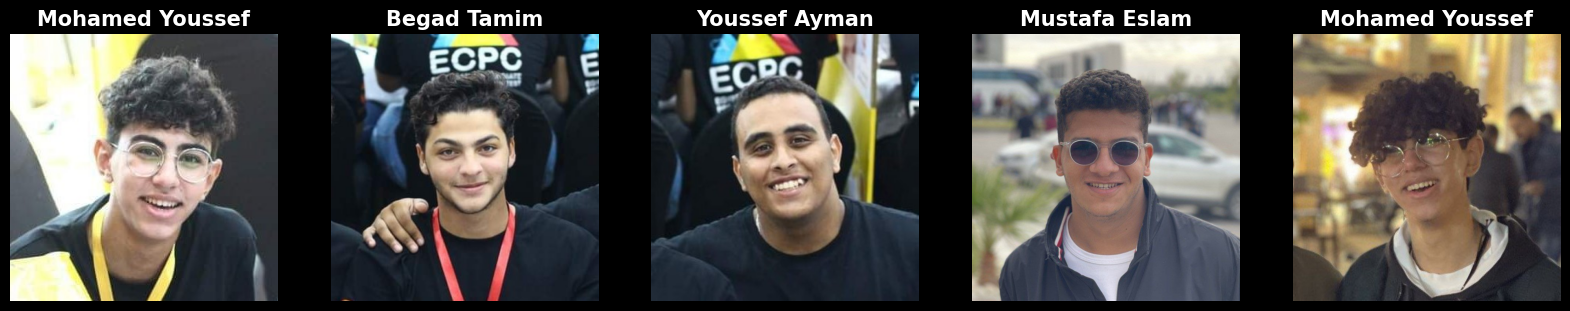

In [176]:
# Displaying 5 random test images
plt.figure(figsize=(20, 6))

# Selecting 5 unique random indices
random_indices = np.random.choice(test_df.index, size=5, replace=False)

for i, random_index in enumerate(random_indices):
    img_pixels = test_df.loc[random_index, "Image Pixels"]
    img_pixels = cv2.cvtColor(img_pixels, cv2.COLOR_BGR2RGB)  # Apply color conversion
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pixels)
    plt.title(test_df.loc[random_index, "Name"], fontsize=15, fontweight="bold")
    plt.axis("off")

##### Normalizing Testing Images

In [177]:
# Resizing and normalizing the image pixels
test_df["Normalized Image Pixels"] = test_df["Image Pixels"].apply(resize_normalize_img)

In [178]:
# Displaying 5 random rows of the data
test_df.sample(5)

,Name,Age at Photo,Gender,Image Pixels,Normalized Image Pixels
15,Mohamed Youssef,19,1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[[1. 1. 1.], [1. 1. 1.], [1. 1. 1.], [1. 1. ..."
2,Abdelrahman Saaed,20,1,"[[[3, 2, 11], [3, 2, 11], [3, 2, 11], [3, 2, 1...","[[[[-0.9764706 -0.9843137 -0.9137255], [-0.976..."
6,Fouad Ouda,20,1,"[[[93, 117, 129], [90, 114, 126], [86, 110, 12...","[[[[-0.27058822 -0.08235294 0.01176476], [-0...."
10,Mohamed Abdelraheem,19,1,"[[[3, 30, 27], [9, 34, 30], [14, 35, 32], [27,...","[[[[-0.92156863 -0.70980394 -0.73333335], [-0...."
4,Begad Tamim,20,1,"[[[254, 254, 238], [255, 255, 239], [255, 255,...","[[[[0.99215686 0.9843137 0.85882354], [1. ..."


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


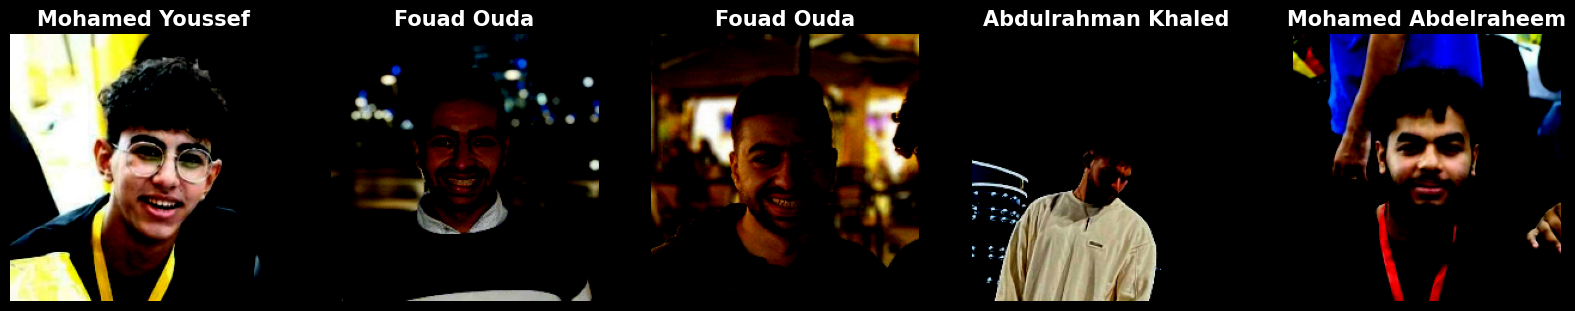

In [182]:
# Displaying 5 random normalized test images
plt.figure(figsize=(20, 6))

# Selecting 5 unique random indices
random_indices = np.random.choice(test_df.index, size=5, replace=False)

for i, random_index in enumerate(random_indices):
    img_pixels = test_df["Normalized Image Pixels"][random_index]
    img_pixels = img_pixels[0]  # Removing the extra dimension
    img_pixels = cv2.cvtColor(img_pixels, cv2.COLOR_BGR2RGB)  # Apply color conversion
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pixels)
    plt.title(test_df["Name"][random_index], fontsize=15, fontweight="bold")
    plt.axis("off")

In [183]:
# Showing the dimensions of the image pixels
print("Dimensions of the image pixels:", test_df["Normalized Image Pixels"][2].shape)

Dimensions of the image pixels: (1, 224, 224, 3)


##### Predicting Face Vector Representaion for the Test Images

In [185]:
# Getting the face vector representation of the normalized test image pixels
tic = time.time()
test_df["Face Vector"] = test_df["Normalized Image Pixels"].apply(get_vector_face)
toc = time.time()
face_vector_time = str(timedelta(seconds=round(toc - tic, 2)))
print("Time taken to get face vectors:", face_vector_time)

1/1 [==============================] - 0s 25ms/step
Time taken to get face vectors: 0:00:02.430000


In [186]:
# Displaying 5 random rows of the data
test_df.sample(5)

,Name,Age at Photo,Gender,Image Pixels,Normalized Image Pixels,Face Vector
12,Mohamed Refaat,19,1,"[[[3, 2, 11], [3, 2, 11], [3, 2, 11], [3, 2, 1...","[[[[-0.9764706 -0.9843137 -0.9137255], [-0.976...","[0.010639378, 0.007020085, 0.026654368, -0.001..."
11,Mohamed Refaat,19,1,"[[[53, 29, 23], [53, 29, 23], [53, 29, 23], [5...","[[[[-0.58431375 -0.77254903 -0.81960785], [-0....","[-0.0023476654, 0.010318967, 0.047239155, 0.00..."
10,Mohamed Abdelraheem,19,1,"[[[3, 30, 27], [9, 34, 30], [14, 35, 32], [27,...","[[[[-0.92156863 -0.70980394 -0.73333335], [-0....","[0.025801407, 0.017760495, 0.033367723, 0.0115..."
4,Begad Tamim,20,1,"[[[254, 254, 238], [255, 255, 239], [255, 255,...","[[[[0.99215686 0.9843137 0.85882354], [1. ...","[0.008615254, 0.012883699, 0.031964447, 0.0036..."
8,Fouad Ouda,20,1,"[[[21, 12, 9], [23, 14, 11], [25, 16, 13], [18...","[[[[-0.85882354 -0.92941177 -0.9529412 ], [-0....","[0.006635495, 0.0035123806, 0.020406006, 0.009..."


### Finding Similarities Between the Celebrities Image's and Test Image's Face Representations 

In [188]:
# Creating a function to calculate the cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [189]:
# Creating a function to get the top 5 most similar celebrities to the test image
def get_top_5_similar_celebs(test_img_vector):
    # Creating a dataframe to store the cosine similarity between the test image and the celebrities
    similarity_df = pd.DataFrame(columns=["Name", "Similarity"])

    # Calculating the cosine similarity between the test image and the celebrities
    for i in range(len(data_df)):
        similarity_df.loc[i, "Name"] = data_df.loc[i, "Celebrity Name"]
        similarity_df.loc[i, "Similarity"] = cosine_similarity(
            test_img_vector, data_df.loc[i, "Face Vector"]
        )

    # Sorting the dataframe by the similarity column in descending order
    similarity_df.sort_values(by="Similarity", ascending=False, inplace=True)

    # Getting the top 5 most similar celebrities to the test image
    top_5_similar_celebs = similarity_df.iloc[:5, :]

    return top_5_similar_celebs

In [190]:
# Getting the top 5 most similar celebrities to the test image
tic = time.time()
test_df["Top 5 Similar Celebs"] = test_df["Face Vector"].apply(get_top_5_similar_celebs)
toc = time.time()
similarity_time = str(timedelta(seconds=round(toc - tic, 2)))
print(
    "Time taken to get top 5 similar celebrities for each testing image:",
    similarity_time,
)

Time taken to get top 5 similar celebrities for each testing image: 0:03:16.750000
